In [24]:
import pandas as pd
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [26]:
def parse_and_pad_column(col, maxlen=200):
    vectors = df[col].apply(lambda x: np.array(eval(x)))
    padded = pad_sequences(vectors, maxlen=maxlen, padding='post', dtype='float32')
    return padded

max_len = 200

x1 = parse_and_pad_column("code1_vecMark", maxlen=max_len)
x2 = parse_and_pad_column("code2_vecMark", maxlen=max_len)
y = df["result"].values
splits = df["split"]

x1 = np.expand_dims(x1, axis=-1)
x2 = np.expand_dims(x2, axis=-1)

In [27]:
x1_train = x1[splits == "train"]
x2_train = x2[splits == "train"]
y_train = y[splits == "train"]

x1_val = x1[splits == "validation"]
x2_val = x2[splits == "validation"]
y_val = y[splits == "validation"]

x1_test = x1[splits == "test"]
x2_test = x2[splits == "test"]
y_test = y[splits == "test"]

In [28]:
from tensorflow.keras.optimizers import Adam

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 5, activation='relu', padding='same')(input_layer)
    x = GlobalMaxPooling1D()(x)
    return input_layer, x

input_shape = (max_len, 1)
input1, out1 = build_branch(input_shape)
input2, out2 = build_branch(input_shape)

merged = Concatenate()([out1, out2])
x = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 200, 128)             768       ['input_7[0][0]']             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 200, 128)             768       ['input_8[0][0]']             
                                                                                            

In [29]:
model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=200,
    batch_size=32
)


Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 0.6946 - accuracy: 0.5088 - val_loss: 0.6918 - val_accuracy: 0.5300
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4938 - val_loss: 0.6947 - val_accuracy: 0.4700
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4975 - val_loss: 0.6959 - val_accuracy: 0.4700
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5188 - val_loss: 0.6975 - val_accuracy: 0.4700
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4837 - val_loss: 0.6893 - val_accuracy: 0.5300
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5175 - val_loss: 0.6960 - val_accuracy: 0.4700
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5500 - val_loss: 0.6889 - val_accuracy: 0.5800
Epoch 8/200
2

In [30]:
loss, accuracy = model.evaluate([x1_test, x2_test], y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

4/4 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.6300

Test Accuracy: 0.6300


4/4 [==============================] - 0s 2ms/step


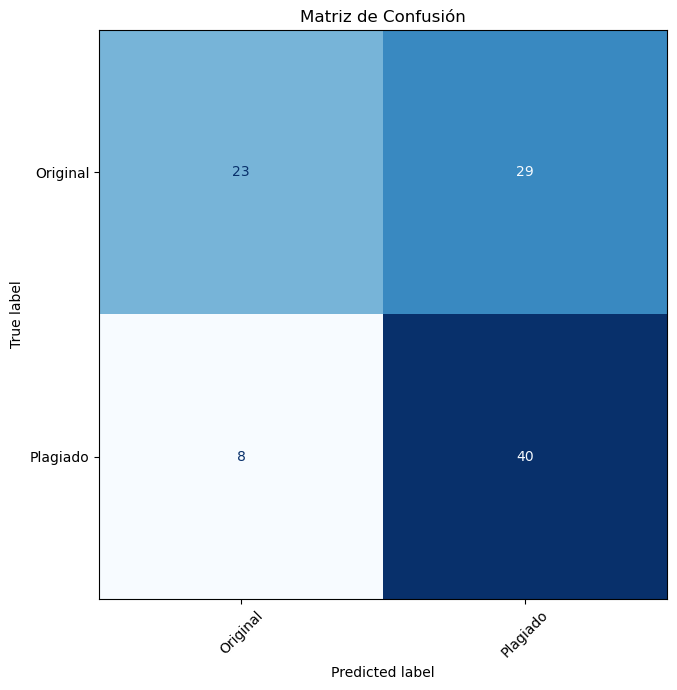


Reporte de clasificación:

              precision    recall  f1-score   support

    Original       0.74      0.44      0.55        52
    Plagiado       0.58      0.83      0.68        48

    accuracy                           0.63       100
   macro avg       0.66      0.64      0.62       100
weighted avg       0.66      0.63      0.62       100



In [31]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


y_pred = (model.predict([x1_test, x2_test]) > 0.5).astype(int).flatten()
labels = ["Original", "Plagiado"]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.xticks(rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))